
# Boston Liquor License Equity & Concentration Analysis

This notebook analyzes liquor license distribution in Boston with a focus on:

- Equity of access by ZIP code
- Market concentration
- Gatekeeping effects
- Policy compliance

Data Source: Licensing Board Minutes (2020–2026)


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (10,6)


In [27]:
sam = pd.read_csv(
    "/Users/dan/Downloads/boston-liquor/live_street_address_management_sam_addresses.csv",
    dtype={
        "ZIP_CODE": str,
        "RANGE_FROM": str,
        "RANGE_TO": str,
        "STREET_SUFFIX_DIR": str,
        "PARCEL": str,
        "created_date": str
    },
    low_memory=False
)

In [28]:
# Ensure ZIP_CODE is a string
sam['ZIP_CODE'] = sam['ZIP_CODE'].astype(str).str.zfill(5)

# Get unique ZIP codes
unique_zips = sam['ZIP_CODE'].unique()

# Optionally sort them
unique_zips = sorted(unique_zips)

print(unique_zips)


['02026', '02108', '02109', '02110', '02111', '02113', '02114', '02115', '02116', '02118', '02119', '02120', '02121', '02122', '02124', '02125', '02126', '02127', '02128', '02129', '02130', '02131', '02132', '02134', '02135', '02136', '02152', '02163', '02186', '02199', '02210', '02215', '02445', '02446', '02458', '02467']


In [31]:
import geopandas as gpd

# Load Boston ZCTA GeoJSON
boston_map = gpd.read_file("../data/boston_zcta.geojson")

# Inspect
boston_map.head()

,ZCTA5CE20,GEOID20,GEOIDFQ20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,02132,02132,860Z200US02132,B5,G6350,S,12597745,248598,+42.2790822,-071.1604493,"POLYGON ((-71.19123 42.283, -71.19119 42.28304..."
1,02116,02116,860Z200US02116,B5,G6350,S,1681929,429920,+42.3509789,-071.0765907,"POLYGON ((-71.09124 42.35434, -71.091 42.3544,..."
2,02163,02163,860Z200US02163,B5,G6350,S,475171,0,+42.3672264,-071.1250920,"POLYGON ((-71.13107 42.36703, -71.13105 42.367..."
3,02186,02186,860Z200US02186,B5,G6350,S,35472536,1251664,+42.2415592,-071.0824366,"POLYGON ((-71.13075 42.22791, -71.13072 42.227..."
4,02135,02135,860Z200US02135,B5,G6350,S,6732791,118310,+42.3496885,-071.1539638,"POLYGON ((-71.17485 42.35034, -71.1748 42.3505..."


## Load and Clean Data

In [3]:

df = pd.read_excel("../data/licenses.xlsx")

df["minutes_date"] = pd.to_datetime(df["minutes_date"], errors="coerce")

df["zipcode"] = (
    df["zipcode"]
    .astype("Int64")
    .astype(str)
    .str.zfill(5)
)

df["status"] = df["status"].str.lower()

df.head()


,minutes_date,license_number,business_name,dba_name,address,street_number,street_name,city,state,zipcode,alcohol_type,manager,attorney,status,status_detail,details,entity_number,file_name
0,2026-01-28,LB-99709,"'Wichcraft, LLC",New England Wicked Craft Company,"54 Salem St, Boston, MA 02113",54,Salem St,Boston,MA,02113,wines and malt beverages,NaN,NaN,granted,Granted,Holder of a Common Victualler 7 Day Wines and ...,13,voting_minutes_2026-01-29.pdf
1,2026-01-28,LB-99286,Alasty Corp.,Napper Tandy's,"4187-4195 Washington St, Roslindale, MA 02131",4187-4195,Washington St,Roslindale,MA,02131,all alcoholic beverages,Callejas,Mark A. White,continued,Continued to the February 11 Transactional Hea...,Holder of a Common Victualler 7 Day All-Alcoho...,15,voting_minutes_2026-01-29.pdf
2,2026-01-28,LB-100327,"AYA Pizza, LLC",Red Line Pizza,"580-582 Dorchester Ave, South Boston, MA 02127",580-582,Dorchester Ave,South Boston,MA,02127,all alcoholic beverages,NaN,NaN,granted,"Granted, for delivery only between 11:00 PM an...",Holder of a Common Victualler License has peti...,2,voting_minutes_2026-01-29.pdf
3,2026-01-28,LB-99607,"Bop Productions, LLC",Bebop,"1116 Boylston St, Boston, MA 02115",1116,Boylston St,Boston,MA,02115,wines and malt beverages,NaN,NaN,granted,Granted,Holder of a Common Victualler 7 Day Wines and ...,12,voting_minutes_2026-01-29.pdf
4,2026-01-28,LB-454368,"BPM Events, LLC",Boston Public Market,"100 Hanover St, Boston, MA 02108",100,Hanover St,Boston,MA,02108,all alcoholic beverages,NaN,Dennis A. Quilty,granted,Granted,Holder of a Common Victualler 7 Day All-Alcoho...,5,voting_minutes_2026-01-29.pdf


## Basic Overview

In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 2388 entries, 0 to 2387
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   minutes_date    2388 non-null   datetime64[us]
 1   license_number  2388 non-null   str           
 2   business_name   2388 non-null   str           
 3   dba_name        2126 non-null   str           
 4   address         2385 non-null   str           
 5   street_number   2317 non-null   str           
 6   street_name     2384 non-null   str           
 7   city            2385 non-null   str           
 8   state           2380 non-null   str           
 9   zipcode         2384 non-null   str           
 10  alcohol_type    2299 non-null   str           
 11  manager         1076 non-null   str           
 12  attorney        1512 non-null   str           
 13  status          2356 non-null   str           
 14  status_detail   2358 non-null   str           
 15  details        

In [5]:
df.describe(include='all')

,minutes_date,license_number,business_name,dba_name,address,street_number,street_name,city,state,zipcode,alcohol_type,manager,attorney,status,status_detail,details,entity_number,file_name
count,2388,2388,2388,2126,2385,2317,2384,2385,2380,2384,2299,1076,1512,2356,2358,2385,2388.000000,2388
unique,NaN,1496,1704,1449,1868,882,329,16,1,29,2,869,219,6,216,2181,NaN,132
top,NaN,LB-99098,"Colwen Management, Inc.",Star Market,"100 Legends Way, Boston, MA 02114",1,Boylston St,Boston,MA,02116,all alcoholic beverages,Patel,Dennis A. Quilty,granted,Granted,Holder of a Common Victualler 7 Day All-Alcoho...,NaN,voting_minutes_2025-08-28.pdf
freq,NaN,8,13,10,16,87,140,1376,2380,273,1715,10,188,2066,1554,11,NaN,40
mean,2023-04-13 16:43:25.025125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.092127,NaN
min,2020-04-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
25%,2021-11-17 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN
50%,2023-03-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.000000,NaN
75%,2024-09-30 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.000000,NaN
max,2026-01-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.000000,NaN


## Filter Granted Licenses

In [6]:

granted = df[df["status"] == "granted"].copy()
len(granted)


2066

## Equity Analysis: Licenses per ZIP

In [7]:

licenses_by_zip = (
    granted.groupby("zipcode")
    .size()
    .reset_index(name="licenses")
    .sort_values("licenses", ascending=False)
)

licenses_by_zip.head(10)


,zipcode,licenses
7,02116,256
17,02128,215
26,02210,179
27,02215,130
5,02114,122
16,02127,106
6,02115,95
3,02111,90
22,02134,83
1,02109,77


## Census Overlay (Optional)

In [20]:
# Force ZIP codes to strings when loading census data
census = pd.read_csv("../data/census_zip_pop.csv", dtype={"zipcode": str})

# Make sure your licenses ZIPs are also strings and zero-padded
licenses_by_zip["zipcode"] = licenses_by_zip["zipcode"].astype(str).str.zfill(5)

# Now merge safely
merged = licenses_by_zip.merge(census, on="zipcode")

merged.head()
merged.columns


Index(['zipcode', 'licenses', 'population', 'poverty_rate', 'median_income',
       'median_gross_rent', 'rent_burden'],
      dtype='str')

In [21]:
# Ensure ZIP codes are strings and padded
merged["zipcode"] = merged["zipcode"].astype(str).str.zfill(5)

# Licenses per 10k people
merged["licenses_per_10k"] = merged["licenses"] / merged["population"] * 10000

# City average per-capita licenses
city_avg = merged["licenses_per_10k"].mean()

# Equity index = relative to city average
merged["equity_index"] = merged["licenses_per_10k"] / city_avg

# Display top/bottom ZIPs by equity index
merged.sort_values("equity_index", ascending=False)[["zipcode", "licenses", "population", "licenses_per_10k", "equity_index"]].head(10)


,zipcode,licenses,population,licenses_per_10k,equity_index
17,02199,45,1221,368.550369,5.024844
10,02110,74,2337,316.645272,4.317166
2,02210,179,5706,313.704872,4.277076
9,02109,77,3559,216.352908,2.949772
13,02108,60,4218,142.247511,1.939414
0,02116,256,22286,114.870322,1.566151
7,02111,90,8417,106.926458,1.457844
4,02114,122,13356,91.344714,1.245401
14,02113,60,6688,89.712919,1.223153
3,02215,130,24522,53.013620,0.722792


In [22]:
# Optional: weighted “socioeconomic equity score”
# High poverty + low access → high need
merged["socioeconomic_equity"] = (1 - merged["equity_index"]) * merged["poverty_rate"]

# Optional: rank ZIPs by need
merged["equity_rank"] = merged["socioeconomic_equity"].rank(ascending=False)

# Preview
merged[["zipcode","licenses","population","licenses_per_10k","equity_index","poverty_rate","socioeconomic_equity","equity_rank"]].head(10)


,zipcode,licenses,population,licenses_per_10k,equity_index,poverty_rate,socioeconomic_equity,equity_rank
0,02116,256,22286,114.870322,1.566151,0.133537,-0.075602,23.0
1,02128,215,45357,47.401724,0.646279,0.141610,0.050090,17.0
2,02210,179,5706,313.704872,4.277076,0.033824,-0.110844,24.0
3,02215,130,24522,53.013620,0.722792,0.171519,0.047547,18.0
4,02114,122,13356,91.344714,1.245401,0.108715,-0.026679,22.0
5,02127,106,36175,29.302004,0.399506,0.104022,0.062465,15.0
6,02115,95,27838,34.126015,0.465277,0.204109,0.109142,10.0
7,02111,90,8417,106.926458,1.457844,0.249376,-0.114175,25.0
8,02134,83,17969,46.190662,0.629767,0.212588,0.078707,14.0
9,02109,77,3559,216.352908,2.949772,0.068278,-0.133126,27.0


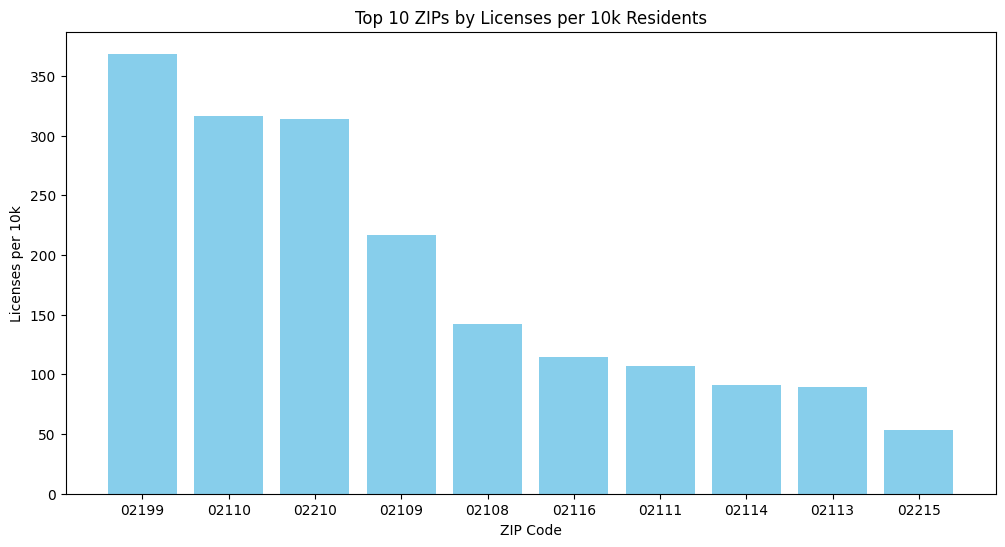

In [23]:
import matplotlib.pyplot as plt

top10 = merged.sort_values("licenses_per_10k", ascending=False).head(10)

plt.figure(figsize=(12,6))
plt.bar(top10["zipcode"], top10["licenses_per_10k"], color="skyblue")
plt.title("Top 10 ZIPs by Licenses per 10k Residents")
plt.ylabel("Licenses per 10k")
plt.xlabel("ZIP Code")
plt.show()


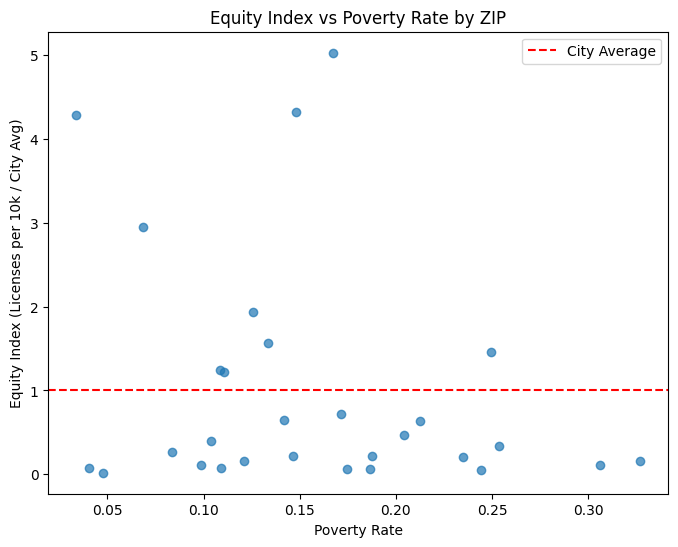

In [24]:
plt.figure(figsize=(8,6))
plt.scatter(merged["poverty_rate"], merged["equity_index"], alpha=0.7)
plt.axhline(1, color='red', linestyle='--', label='City Average')
plt.xlabel("Poverty Rate")
plt.ylabel("Equity Index (Licenses per 10k / City Avg)")
plt.title("Equity Index vs Poverty Rate by ZIP")
plt.legend()
plt.show()


In [32]:
# Ensure ZIP codes are strings and zero-padded
merged["zipcode"] = merged["zipcode"].astype(str).str.zfill(5)
boston_map["ZCTA5CE20"] = boston_map["ZCTA5CE20"].astype(str).str.zfill(5)

# Merge equity metrics into GeoDataFrame
map_df = boston_map.merge(merged, left_on="ZCTA5CE20", right_on="zipcode")


In [34]:
# Ensure numeric types
merged["population"] = pd.to_numeric(merged["population"], errors="coerce")
merged["licenses"] = pd.to_numeric(merged["licenses"], errors="coerce")

# Licenses per 10k residents
merged["licenses_per_10k"] = merged["licenses"] / merged["population"] * 10000

# Boston average per-capita licenses
city_avg = merged["licenses_per_10k"].mean()

# Equity index relative to city average
merged["equity_index"] = merged["licenses_per_10k"] / city_avg

# Optional: clamp extremes for plotting
merged["equity_index_clamped"] = merged["equity_index"].clip(0, 2)

# Check distribution
merged[["zipcode","licenses","population","licenses_per_10k","equity_index"]].sort_values("equity_index")


,zipcode,licenses,population,licenses_per_10k,equity_index
28,02467,3,21709,1.381915,0.018841
26,02121,12,29820,4.024145,0.054866
27,02126,11,24994,4.401056,0.060004
20,02124,28,55336,5.059997,0.068988
25,02132,14,26488,5.285412,0.072062
22,02136,23,39498,5.823080,0.079392
23,02119,21,26821,7.829686,0.106751
21,02131,26,31637,8.218225,0.112048
15,02130,49,41479,11.813207,0.161062
24,02120,17,14364,11.835143,0.161361


<Figure size 1000x1000 with 0 Axes>

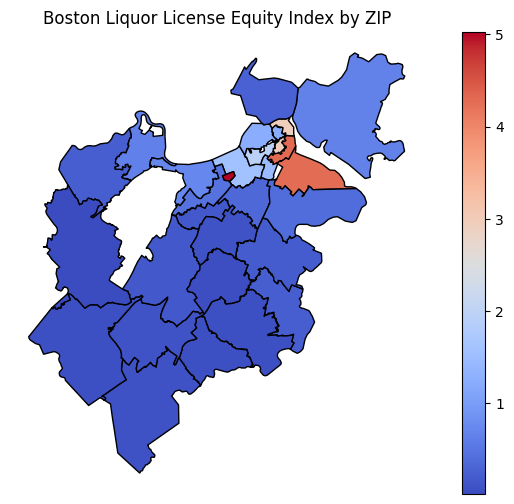

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
map_df.plot(
    column="equity_index",      # Metric to color by
    cmap="coolwarm",            # Color map
    legend=True,                # Show legend
    edgecolor="black"
)
plt.title("Boston Liquor License Equity Index by ZIP")
plt.axis("off")
plt.show()


“While Boston’s liquor licenses are not monopolized, nearly one-third are held by multi-location operators — raising questions about whether independent and first-time owners face structural disadvantages.”


The Herfindahl–Hirschman Index (HHI) for liquor license ownership in Boston is approximately 10.7, indicating a highly fragmented ownership structure with no evidence of monopolization or dominant firms. At the same time, multi-location operators account for approximately 31.6% of all granted licenses. Taken together, these measures suggest that while ownership is broadly dispersed, a substantial minority of licenses are held by multi-location operators. 



## Market Concentration (HHI)

In [8]:

owners = granted.groupby("business_name").size()
shares = owners / owners.sum()

hhi = (shares ** 2).sum() * 10000
hhi


np.float64(10.697327027080215)

In [9]:

top10 = owners.sort_values(ascending=False).head(10)
top10


business_name
Colwen Management, Inc.              13
Air Ventures, LLC                    12
Massachusetts Sportservice, Inc.     12
Sodexo Operations, LLC               11
Delaware North Boston Flight, LLC    10
Delta Air Lines, Inc.                10
RBSBW, INC.                           8
Night Shift Lovejoy, LLC              8
LEGAL SEA FOODS, LLC                  7
American Multi-Cinema, Inc.           7
dtype: int64

## Chain Penetration

In [10]:

locations = (
    granted.groupby("business_name")["address"]
    .nunique()
    .reset_index(name="locations")
)

chains = locations[locations["locations"] > 1]

chain_licenses = granted[
    granted["business_name"].isin(chains["business_name"])
]

chain_index = len(chain_licenses) / len(granted)
chain_index


0.31606969990319456

## Attorney Gatekeeping

In [11]:

attorney_stats = (
    granted.dropna(subset=["attorney"])
    .groupby("attorney")
    .size()
    .reset_index(name="cases")
)

success = (
    granted.groupby("attorney")["status"]
    .apply(lambda x: (x=="granted").mean())
    .reset_index(name="success_rate")
)

attorney_stats = attorney_stats.merge(success, on="attorney", how="left")

attorney_stats.sort_values("cases", ascending=False).head(10)


,attorney,cases,success_rate
57,Dennis A. Quilty,166,1.0
16,Andrew F. Upton,99,1.0
188,Thomas P. Miller,89,1.0
104,Joseph H. Devlin,80,1.0
120,Kristen L. Scanlon,67,1.0
103,Jon D. Aieta,45,1.0
67,Elizabeth Pisano,44,1.0
100,John P. Connell,43,1.0
156,Nicholas J. Zozula,27,1.0
161,Patricia Lang Farnsworth,26,1.0


## Temporal Trends

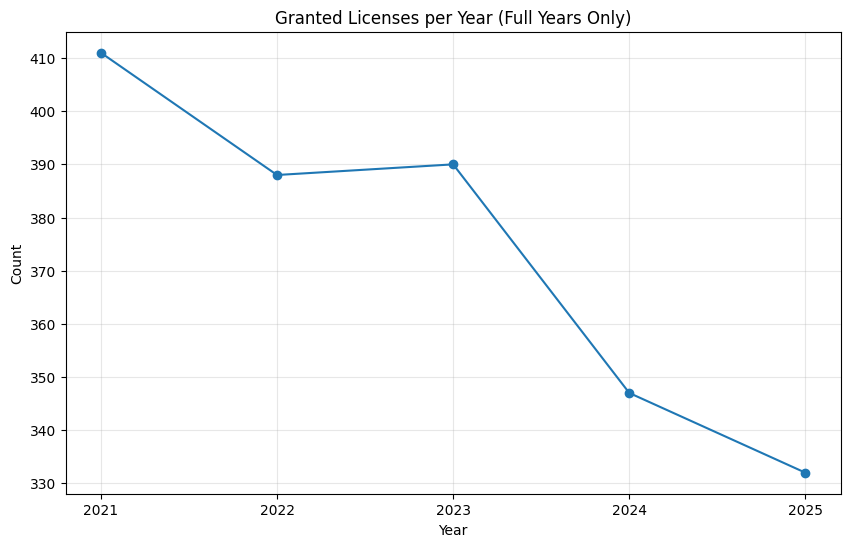

In [16]:
import matplotlib.ticker as mticker

# Plot
plt.figure()
full_years.plot(marker="o")

plt.title("Granted Licenses per Year (Full Years Only)")
plt.ylabel("Count")
plt.xlabel("Year")
plt.grid(True, alpha=0.3)

# Force integer ticks
ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

plt.show()




## ZIP Code Distribution

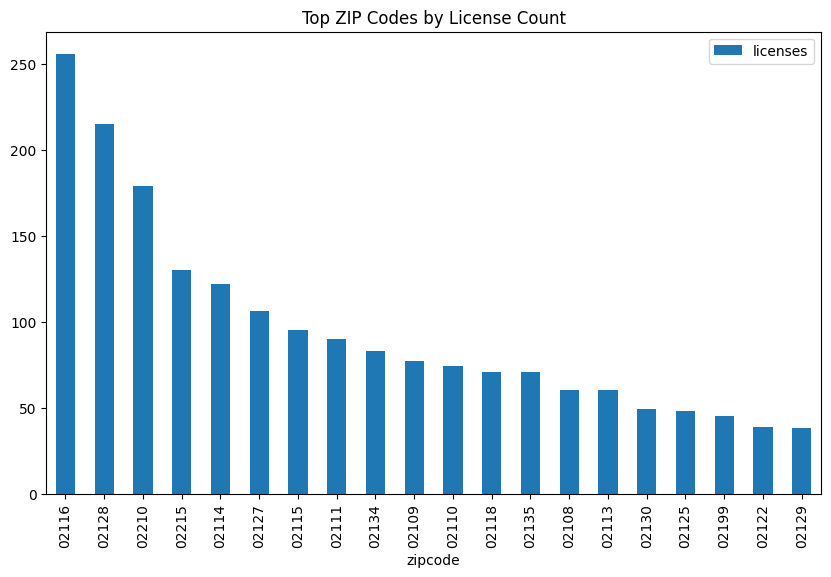

In [13]:

licenses_by_zip.head(20).plot(
    x="zipcode",
    y="licenses",
    kind="bar"
)

plt.title("Top ZIP Codes by License Count")
plt.show()



## Key Findings (Draft)

Fill in after analysis.



## Methodology

- Source: Licensing Board Minutes PDFs
- Processing: Custom ETL
- Limitations noted.
